In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import load_google_mobility, load_deaths, load_interventions, load_counties, load_google_mobility_time_series
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

Mobility Last Updated 04-26
Deaths Last Updated 04-26


In [4]:
# Ignore places with FIPS missing
deaths = deaths.dropna(axis=0, subset=['FIPS']).astype({'FIPS':'int32'})

## Example County

In [308]:
# Get columns that are dates
cause_dates = get_date_columns(mobility_ts, return_dtimes=False)
effect_dates = get_date_columns(deaths, return_dtimes=False)

FIPS = 34013#53005#36053#
qm = mobility_ts[mobility_ts['FIPS'] == FIPS].iloc[0][cause_dates]
qd = deaths[deaths['FIPS'] == FIPS].iloc[0][effect_dates] / counties[counties['FIPS'] == FIPS]['POP_ESTIMATE_2018'].iloc[0]

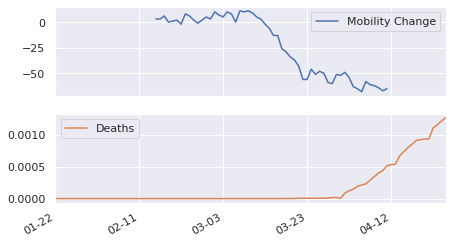

In [309]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(7, 4)})
axes = pd.concat([qm.rename('Mobility Change'),qd.rename('Deaths')],axis=1).plot(subplots=True)

## Normalize
Let the deaths $D_t$ be modeled based on $R_0$ and some arbitrary time growth $t$ such that 

$$D_t \sim D_{t-1}R_0 \sim R_0^t $$.

This occurs at normal mobility levels, and we note that with percent mobility change from normal $(m=-100\%)$, the deaths will stop increasing. Thus the modified $R_0$ based on mobility is 

$$D_t \sim [R_0(1 + \frac{m}{100})]^t = \prod_{i=1}^{t}[R_0(1 + \frac{m}{100})]$$.

This is what we observe, or more specifically we observe it with time dependent mobility $m_t$. So our observation is

$$D_t \sim \prod_{i=1}^{t}[R_0(1 + \frac{m_i}{100})]$$.

Dividing out by the mobility terms to obtain the death curve without it, we achieve

$$D_t \prod_{i=1}^{t}\frac{1}{1 + \frac{m_i}{100}}$$

We can also use this to obtain $R_0$, especially if we take it to be a time dependent $R_t$.

$$R_t \sim (\frac{D_t}{D_{t-1}})(\frac{1}{1 + \frac{m_t}{100}})$$


In [310]:
match_col = 'FIPS'
lag = 18
matched_dfs,(cause_dates, effect_dates), date_idx = align_lagged_dates(mobility_ts, deaths, match_col, lag=lag)

In [317]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def normalize(df, n=3):
    norm = df.iloc[0].to_numpy()
    a = df.iloc[1].to_numpy()
    norm = moving_average(norm, n=n)
    a = moving_average(a, n=n)
    #return(np.divide(a,np.exp(0.5+norm/100)))
    # R0
    factor = (1 + norm/100)
    at = a[1:]
    at0 = a[:-1]
    ratio = np.divide(at,at0)
    # return(np.divide(ratio, factor[1:]))
    # norm death
    return(np.divide(a, np.cumprod(factor)))

In [318]:
ma = 3
deaths_normed = matched_dfs.groupby(match_col).apply(lambda x: normalize(x[date_idx], n=ma))

In [323]:
deaths_normed = pd.DataFrame.from_items(zip(deaths_normed.index, deaths_normed.values)).T
deaths_normed.columns = effect_dates[-len(date_idx):][:-ma+1]

In [324]:
deaths_normed.head(3)

,03-06,03-07,03-08,03-09,03-10,03-11,03-12,03-13,03-14,03-15,...,04-13,04-14,04-15,04-16,04-17,04-18,04-19,04-20,04-21,04-22
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.153407,3.198129,6.270841,11.415365,17.713498,19.005899,19.328033,27.222581,55.480805,112.208369
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.589490,5.357566,9.510472,16.882494,28.137491,54.409512,100.836162,196.717945,373.515086,742.082953
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [325]:
## Example
#FIPS = 53005#34013
county_deaths_normed = deaths_normed.loc[FIPS]

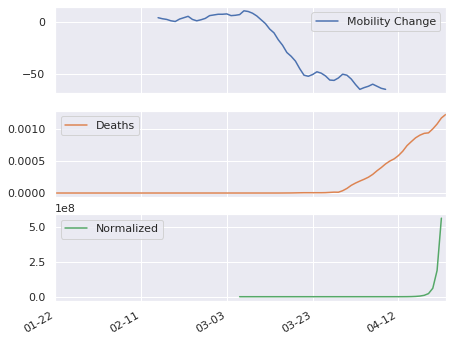

In [326]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(7, 6)})
axes = pd.concat(
    [
    pd.Series(moving_average(qm.values, n=ma),index=qm.index[:-(ma-1)]).rename('Mobility Change'),
    pd.Series(moving_average(qd.values, n=ma),index=qd.index[:-(ma-1)]).rename('Deaths'),
    county_deaths_normed.rename('Normalized')
    ],
    axis=1).plot(subplots=True)